## Assignment 2

# 2. Dataset description and Overview
The dataset used for this assignment is a sample from [EMNIST handwritten character dataset - ByClass](https://www.nist.gov/itl/products-and-services/emnist-dataset), a collection of 814,255+ 28 by 28 images with character labels. This smaller sample set can be downloaded from the Google Drive link provided in the assignment specification. The dataset consists of 120000 amount images, of which 100,000 is split into a test set, which was further divided into a validation set after pre-processing, and a testing set of 20,000.

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import sklearn
import time
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import os

drive_path = '/content/drive/MyDrive/EMNIST_Byclass_Small2'

train_dict = pickle.load(open(os.path.join(drive_path, 'emnist_train.pkl'), 'rb'))
test_dict = pickle.load(open(os.path.join(drive_path, 'emnist_test.pkl'), 'rb'))

# Extract the images and labels from the dictionaries
train_images = train_dict['data']
train_labels = train_dict['labels']
test_images = test_dict['data']
test_labels = test_dict['labels']
print("Testing images shape:", test_images.shape)
print("Training images shape:", train_images.shape)
print("Training Labels shape:", train_labels.shape)


Testing images shape: (20000, 28, 28)
Training images shape: (100000, 28, 28)
Training Labels shape: (100000,)


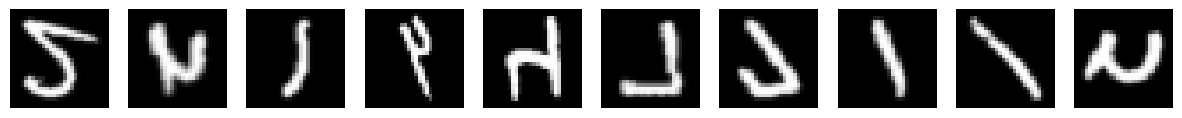

In [ ]:
# Number of images to display
num_images = 10

# Create a figure and axes for the grid
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Iterate through the sample images
for i in range(num_images):
  # Select a random image
  random_index = np.random.randint(0, len(train_images))
  image = np.rot90(train_images[random_index].reshape(28, 28),k=1)
  # Display the image
  axes[i].imshow(image, cmap='gray')
  axes[i].axis('off')

plt.show()


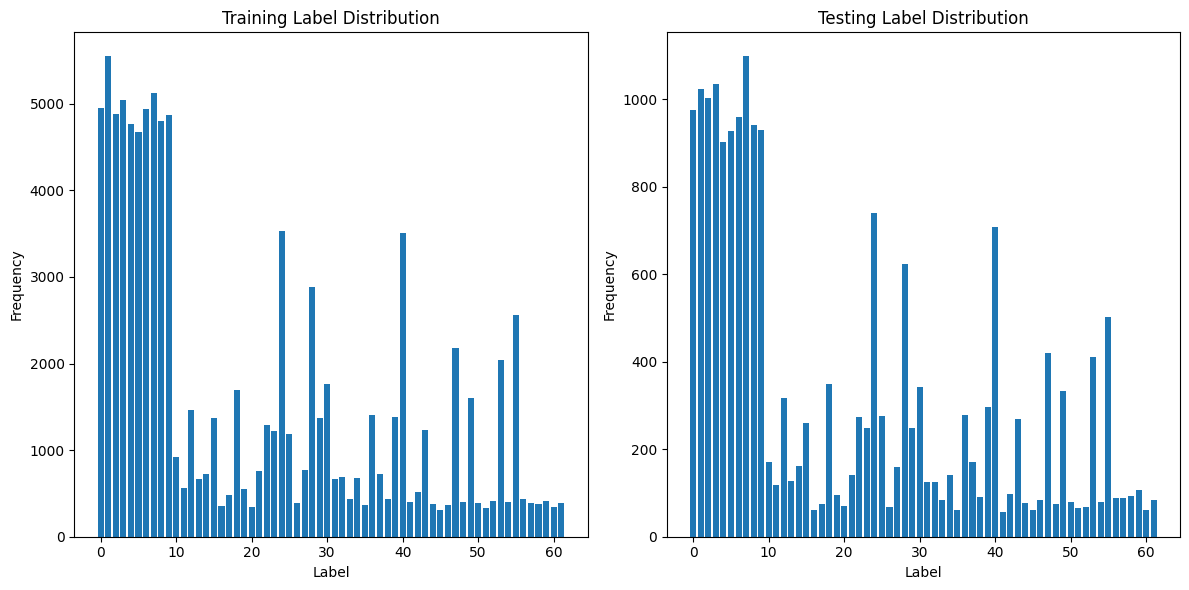

In [ ]:
# Calculate the frequency of each label in the training set
train_label_counts = {}
for label in train_labels:
  if label not in train_label_counts:
    train_label_counts[label] = 0
  train_label_counts[label] += 1

# Calculate the frequency of each label in the testing set
test_label_counts = {}
for label in test_labels:
  if label not in test_label_counts:
    test_label_counts[label] = 0
  test_label_counts[label] += 1


# Plot the histogram of training labels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(train_label_counts.keys(), train_label_counts.values())
plt.title('Training Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

# Plot the histogram of testing labels
plt.subplot(1, 2, 2)
plt.bar(test_label_counts.keys(), test_label_counts.values())
plt.title('Testing Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# 3. Data Preparation

Requred data is provided in a folder that contains a .mat file which is to be loaded in and then XXXX

The folder includes:

Folder details


## 3.1 Merging Classes

Due to the similarities of Uppercase and Lowercase letters, as suggested by the dataset specific images will be merged, for example lowercase 'k' is similar to uppercase "K"


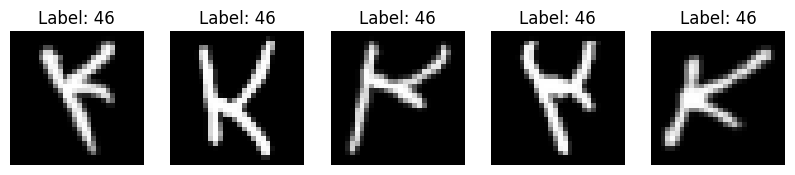

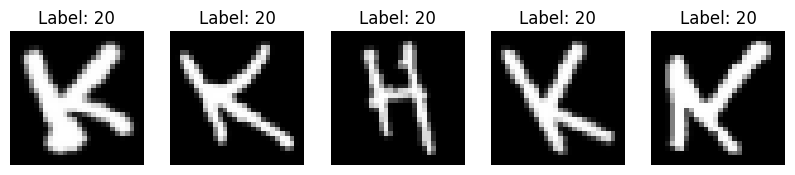

In [ ]:
def display_images_by_label(images, labels, target_label, num_samples=5):
    # Find the indices of images with the target label
    indices = np.where(labels == target_label)[0]

    # Display a few images with the specified label
    if len(indices) == 0:
        print(f"No images found for label {target_label}")
        return

    # Limit to the specified number of samples
    indices = indices[:num_samples]

    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        rotated_image = np.rot90(images[idx].reshape(28, 28), k=1)

        # Display the rotated image
        plt.imshow(rotated_image, cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()

# Example usage:
# For example, 38 is 'c' and 12 is 'C' in the original EMNIST ByClass labels.
display_images_by_label(train_images, train_labels, target_label=46, num_samples=5)  # Display lowercase 'c'
display_images_by_label(train_images, train_labels, target_label=20, num_samples=5)  # Display uppercase 'C'

In [ ]:
merge_dictionary = {
        38: 12,  # 'c' -> 'C'
        44: 18,  # 'i' -> 'I'
        45: 19,  # 'j' -> 'J'
        46: 20,  # 'k' -> 'K'
        47: 21,  # 'l' -> 'L'
        48: 22,  # 'm' -> 'M'
        50: 24,  # 'o' -> 'O'
        51: 25,  # 'p' -> 'P'
        54: 28,  # 's' -> 'S'
        56: 30,  # 'u' -> 'U'
        57: 31,  # 'v' -> 'V'
        58: 32,  # 'w' -> 'W'
        59: 33,  # 'x' -> 'X'
        60: 34,  # 'y' -> 'Y'
        61: 35   # 'z' -> 'Z'
    }

def merge_labels(labels, merge_dictionary):
    merged_labels = np.copy(labels)
    for old_label, new_label in merge_dictionary.items():
        merged_labels[labels == old_label] = new_label
    return merged_labels

#Step 0
# Merge the labels
train_labels = merge_labels(train_labels, merge_dictionary)
test_labels = merge_labels(test_labels, merge_dictionary)
#Print Number of unique labels
print("Number of unique labels in the training set:", len(np.unique(train_labels)))
print("Number of unique labels in the testing set:", len(np.unique(test_labels)))

Number of unique labels in the training set: 47
Number of unique labels in the testing set: 47


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)


# Step 1: Normalize the pixel values (0-255) to the range [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Step 2: Reshape the images for model input
N_train = train_images.shape[0]  # Number of training images
N_test = test_images.shape[0]    # Number of testing images

# Reshape the images to (N, 28, 28, 1)
train_images = train_images.reshape(N_train, 28, 28, 1)
test_images = test_images.reshape(N_test, 28, 28, 1)

# Step 2.5 Validation set
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, train_size=0.9, random_state=42)

# Step 3: Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=10,       # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,   # Randomly shift images horizontally by up to 10% of width
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10% of height
    zoom_range=0.1           # Randomly zoom into images by up to 10%
)

# No augmentation for validation data, just rescaling
valid_datagen = ImageDataGenerator()

# Fit the data generator on the training images
train_datagen.fit(X_train)


# Step 4.5: Class Rebalancing
# Compute class weights to account for class imbalance
classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Summary of preprocessing steps
print("Train images shape (after reshaping):", X_train.shape)
print("Validation images shape:", X_valid.shape)
print("Test images shape (after reshaping):", test_images.shape)
print("Class weights for balancing:", class_weights_dict)


Train images shape (after reshaping): (90000, 28, 28, 1)
Validation images shape: (10000, 28, 28, 1)
Test images shape (after reshaping): (20000, 28, 28, 1)
Class weights for balancing: {0: 0.42954096388992297, 1: 0.38251969976453787, 2: 0.4321583428168081, 3: 0.421968624288514, 4: 0.45098766298193044, 5: 0.4541967782308531, 6: 0.43235349221523517, 7: 0.414120591916366, 8: 0.44357044637972587, 9: 0.43372448856654056, 10: 2.33523611831863, 11: 3.732736095558044, 12: 1.1283993028999861, 13: 3.223726627981947, 14: 2.9459901800327333, 15: 1.5695849319846529, 16: 5.946874587022598, 17: 4.474050507059057, 18: 1.0234599770290094, 19: 2.486874827300359, 20: 3.0638297872340425, 21: 0.7206976353109811, 22: 1.2673021952490249, 23: 1.736077621959453, 24: 0.5440038684719536, 25: 1.435452486522696, 26: 5.733214422219391, 27: 2.7711919204360007, 28: 0.6502185456778529, 29: 1.5442690459849004, 30: 0.9603277918862972, 31: 2.015677491601344, 32: 1.9539730785931393, 33: 2.5772457833395377, 34: 2.11824515

Defining Initial CNN to Expound upon

In [ ]:
# Define the model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ReLU


keras.backend.clear_session()

model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),  # Input shape for EMNIST data

    # First Conv Block
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Second Conv Block
    keras.layers.Conv2D(48, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Third Conv Block
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),

    # Fourth Conv Block
    keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Flatten Layer
    keras.layers.Flatten(),

    # Fully Connected Layers
    keras.layers.Dense(128),  # No activation here, add as a separate layer
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(classes), activation="softmax"),  # Output layer for classification
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 48)          │          13,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 14, 14, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 128)                 │              

 Total params: 288,031 (1.10 MB)

 Trainable params: 286,975 (1.09 MB)

 Non-trainable params: 1,056 (4.12 KB)

In [ ]:
# Compile model with adjusted learning rate for Adam optimizer
learning_rate = 0.0005  # Decreasing the learning rate for better convergence
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Set batch size and number of epochs
batch_size = 128
epochs = 30

# Fit the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=valid_datagen.flow(X_valid, y_valid, batch_size=batch_size),
                    class_weight=class_weights_dict)



Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - accuracy: 0.4076 - loss: 2.3877 - val_accuracy: 0.8222 - val_loss: 0.5772
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.7545 - loss: 0.7274 - val_accuracy: 0.8007 - val_loss: 0.5612
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.7852 - loss: 0.5795 - val_accuracy: 0.8500 - val_loss: 0.4414
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.8057 - loss: 0.5162 - val_accuracy: 0.8487 - val_loss: 0.4202
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.8173 - loss: 0.4660 - val_accuracy: 0.8563 - val_loss: 0.3966
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.8238 - loss: 0.4591 - val_accuracy: 0.8497 - val_loss: 0.3926
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.8269 - loss: 0.4380 - val_accuracy: 0.8185 - val_loss: 0.5130
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.8336 - loss: 0.4147 - val_accurac

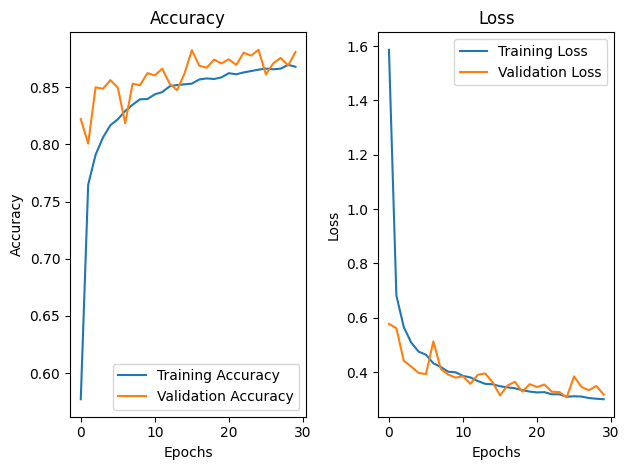

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8813 - loss: 0.3128
Test Loss: 0.3145071268081665
Test Accuracy: 0.8823999762535095
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.77      0.71       976
           1       0.70      0.78      0.74      1023
           2       0.99      0.84      0.91      1003
           3       1.00      0.99      0.99      1035
           4       0.98      0.97      0.97       903
           5       0.89      0.96      0.92       928
           6       0.99      0.95      0.97       959
           7       0.99      0.99      0.99      1098
           8       0.99      0.95      0.97       941
           9       0.94      0.95      0.95       929
          10       0.92      0.97      0.95       170
          11       0.88      0.98      0.93       118
          12       0.96      0.97      0.97       406
          13       0.63      0.96      

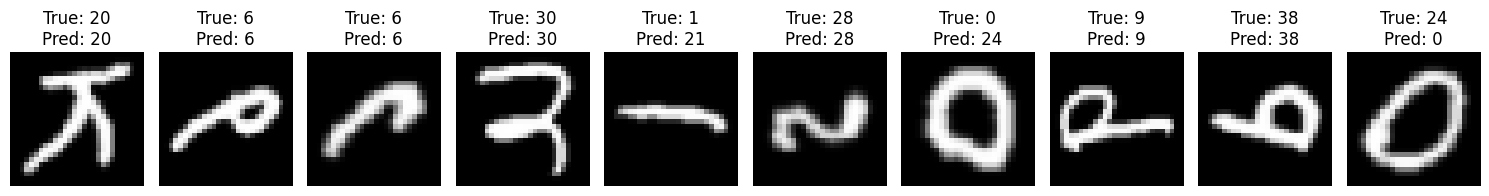

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=64)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 2: Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Generate a classification report
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels))

# Step 5 (Optional): Visualize some test results
num_images_to_display = 10
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i in range(num_images_to_display):
    random_index = np.random.randint(0, len(test_images))
    image = test_images[random_index].reshape(28, 28)
    true_label = test_labels[random_index]
    predicted_label = predicted_labels[random_index]

    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")

plt.tight_layout()
plt.show()

## Setting up Hyperparameter Tuning
